In [3]:
import numpy as np
from pymatching import Matching
import matplotlib.pyplot as plt
from scipy import sparse, linalg
import CompassCodes as cc
import stim 
import pandas as pd
from compass_code_correlated_error import depolarizing_err


In [4]:
pip show stim

Name: stim
Version: 1.14.0
Summary: A fast library for analyzing with quantum stabilizer circuits.
Home-page: https://github.com/quantumlib/stim
Author: Craig Gidney
Author-email: craig.gidney@gmail.com
License: Apache 2
Location: /opt/anaconda3/lib/python3.8/site-packages
Requires: numpy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [5]:
!python --version

Python 3.8.19


In [6]:
surface_code_circuit = stim.Circuit.generated(
    "surface_code:rotated_memory_z",
    rounds=1,
    distance=3,
    # after_clifford_depolarization=0.001,
    # after_reset_flip_probability=0.001,
    before_measure_flip_probability=0.05)
    # before_round_data_depolarization=0.001)

In [7]:
print(repr(surface_code_circuit))

stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8

In [8]:
sc_no_err = stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

In [9]:
sc_err =stim.Circuit('''
    QUBIT_COORDS(1, 1) 1
    QUBIT_COORDS(2, 0) 2
    QUBIT_COORDS(3, 1) 3
    QUBIT_COORDS(5, 1) 5
    QUBIT_COORDS(1, 3) 8
    QUBIT_COORDS(2, 2) 9
    QUBIT_COORDS(3, 3) 10
    QUBIT_COORDS(4, 2) 11
    QUBIT_COORDS(5, 3) 12
    QUBIT_COORDS(6, 2) 13
    QUBIT_COORDS(0, 4) 14
    QUBIT_COORDS(1, 5) 15
    QUBIT_COORDS(2, 4) 16
    QUBIT_COORDS(3, 5) 17
    QUBIT_COORDS(4, 4) 18
    QUBIT_COORDS(5, 5) 19
    QUBIT_COORDS(4, 6) 25
    R 1 3 5 8 10 12 15 17 19 2 9 11 13 14 16 18 25
    TICK
    H 2 11 16 25
    TICK
    CX 2 3 16 17 11 12 15 14 10 9 19 18
    TICK
    CX 2 1 16 15 11 10 8 14 3 9 12 18
    TICK
    CX 16 10 11 5 25 19 8 9 17 18 12 13
    TICK
    CX 16 8 11 3 25 17 1 9 10 18 5 13
    TICK
    H 2 11 16 25
    TICK
    X_ERROR(0.05) 2 9 11 13 14 16 18 25
    MR 2 9 11 13 14 16 18 25
    DETECTOR(0, 4, 0) rec[-4]
    DETECTOR(2, 2, 0) rec[-7]
    DETECTOR(4, 4, 0) rec[-2]
    DETECTOR(6, 2, 0) rec[-5]
    X_ERROR(0.05) 1 3 5 8 10 12 15 17 19
    M 1 3 5 8 10 12 15 17 19
    DETECTOR(0, 4, 1) rec[-3] rec[-6] rec[-13]
    DETECTOR(2, 2, 1) rec[-5] rec[-6] rec[-8] rec[-9] rec[-16]
    DETECTOR(4, 4, 1) rec[-1] rec[-2] rec[-4] rec[-5] rec[-11]
    DETECTOR(6, 2, 1) rec[-4] rec[-7] rec[-14]
    OBSERVABLE_INCLUDE(0) rec[-7] rec[-8] rec[-9]
''')

<pymatching.Matching object with 8 detectors, 0 boundary nodes, and 11 edges>


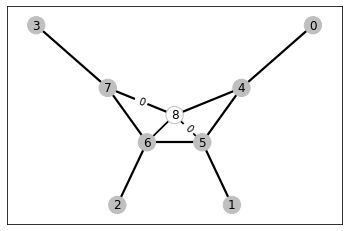

In [10]:
matching_from_c = Matching.from_stim_circuit(sc_err)
matching_from_c.draw()
print(matching_from_c)

In [11]:
d = 5
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

In [12]:
def convert_sparse_to_d(sparse_mat):
    rows, cols, values = sparse.find(sparse_mat)
    d = {}

    for i in range(len(rows)):
        plaq = rows[i]
        qubit = cols[i]

        if plaq not in d:
            d[plaq] = [cols[i]]
        else:
            d[plaq] += [cols[i]]
    sorted_d = dict(sorted(zip(d.keys(),d.values())))
    return sorted_d

d_z = convert_sparse_to_d(H_z)
print(d_z)

d_x = convert_sparse_to_d(H_x)
print(d_x)

{0: [0, 5], 1: [1, 2, 6, 7], 2: [3, 4, 8, 9], 3: [5, 6, 10, 11], 4: [7, 8, 12, 13], 5: [9, 14], 6: [10, 15], 7: [11, 12, 16, 17], 8: [13, 14, 18, 19], 9: [15, 16, 20, 21], 10: [17, 18, 22, 23], 11: [19, 24]}
{0: [0, 1, 5, 6], 1: [10, 11, 15, 16], 2: [20, 21], 3: [1, 2], 4: [6, 7, 11, 12], 5: [16, 17, 21, 22], 6: [2, 3, 7, 8], 7: [12, 13, 17, 18], 8: [22, 23], 9: [3, 4], 10: [8, 9, 13, 14], 11: [18, 19, 23, 24]}


In [13]:
def qubit_to_plaq_d(H):
    """ Makes a dictionary that records which plaquettes belong to qubits
    """
    rows, cols, values = sparse.find(H)
    d = {}
    for i in range(len(cols)):
        q = cols[i]
        plaq = rows[i]

        if q not in d:
            d[q] = [plaq]
        else:
            d[q] += [plaq]
    return d
d = qubit_to_plaq_d(H_x)
print(d)

{0: [0], 1: [0, 3], 2: [3, 6], 3: [6, 9], 4: [9], 5: [0], 6: [0, 4], 7: [4, 6], 8: [6, 10], 9: [10], 10: [1], 11: [1, 4], 12: [4, 7], 13: [7, 10], 14: [10], 15: [1], 16: [1, 5], 17: [5, 7], 18: [7, 11], 19: [11], 20: [2], 21: [2, 5], 22: [5, 8], 23: [8, 11], 24: [11]}


In [14]:
def check_order_d(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    plaq_d = convert_sparse_to_d(H)
    order_d = {0:[], 1:[], 2:[], 3:[]}
    d = int(np.sqrt(H.shape[1]))

    for plaq in plaq_d:
        q_list = plaq_d[plaq] # the list of qubits in the plaquette
        if type == "X":
            if len(q_list) == 2 and max(q_list) <= H.shape[1]//2: # if the two qubit stabilizer is on the top bndry
                order_d[2] += [(q_list[1], plaq)]
                order_d[3] += [(q_list[0], plaq)]
            elif len(q_list) == 2 and max(q_list) >= H.shape[1]//2: # if the two qubit stabilizer is on bottom 
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[0], plaq)]
                order_d[2] += [(q_list[3], plaq)]
                order_d[3] += [(q_list[2], plaq)]
        if type == "Z": 
            if len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d == 0: # if the two qubit stabilizer is on the left bndry
                order_d[0] += [(q_list[0], plaq)]
                order_d[1] += [(q_list[1], plaq)]
            elif len(plaq_d[plaq]) == 2 and (q_list[0]-q_list[1])%d == 0 and q_list[0]%d != 0: # if the two qubit stabilizer is on right bndry 
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[1], plaq)]
            else: # length 4 plaquette
                order_d[0] += [(q_list[1], plaq)]
                order_d[1] += [(q_list[3], plaq)]
                order_d[2] += [(q_list[0], plaq)]
                order_d[3] += [(q_list[2], plaq)]
                
    return order_d

order_d_x = check_order_d(H_x, "X")
print(order_d_x)
order_d_z = check_order_d(H_z, "Z")
print(order_d_z)


{0: [(1, 0), (11, 1), (21, 2), (7, 4), (17, 5), (3, 6), (13, 7), (23, 8), (9, 10), (19, 11)], 1: [(0, 0), (10, 1), (20, 2), (6, 4), (16, 5), (2, 6), (12, 7), (22, 8), (8, 10), (18, 11)], 2: [(6, 0), (16, 1), (2, 3), (12, 4), (22, 5), (8, 6), (18, 7), (4, 9), (14, 10), (24, 11)], 3: [(5, 0), (15, 1), (1, 3), (11, 4), (21, 5), (7, 6), (17, 7), (3, 9), (13, 10), (23, 11)]}
{0: [(0, 0), (2, 1), (4, 2), (6, 3), (8, 4), (10, 6), (12, 7), (14, 8), (16, 9), (18, 10)], 1: [(5, 0), (7, 1), (9, 2), (11, 3), (13, 4), (15, 6), (17, 7), (19, 8), (21, 9), (23, 10)], 2: [(1, 1), (3, 2), (5, 3), (7, 4), (9, 5), (11, 7), (13, 8), (15, 9), (17, 10), (19, 11)], 3: [(6, 1), (8, 2), (10, 3), (12, 4), (14, 5), (16, 7), (18, 8), (20, 9), (22, 10), (24, 11)]}


In [15]:
def make_circuit_from_parity(H_x, H_z, p_err, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix
    """
    
    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    order_d_x = check_order_d(H_x, "X")
    order_d_z = check_order_d(H_z, "Z")
    
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z)
    num_qubits = len(qubit_d_x)
    d = int(np.sqrt(num_qubits))
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())]
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())]
    data_q_list = data_q_x_list

    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(len(plaq_d_x) + len(plaq_d_z))
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x)

    # reset the qubits
    for q in range(len(qubit_d_x)):
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go thru the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        q_z_list = order_d_z[order]
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
        
        circuit.append("TICK")
    
    circuit.append("H", plaq_d_x)
    circuit.append("X_ERROR", full_plaq_L, p_err)
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))
    
        circuit.append("Z_ERROR", data_q_list, p_err)
        circuit.append("MX", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_x: 
            
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_x_list] + [-num_ancillas + anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))
    
        circuit.append("X_ERROR", data_q_list, p_err)
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits + q) for q in range(d)], 0)
    return circuit
            
circuit = make_circuit_from_parity(H_x, H_z, 0.05, "Z")            
print(repr(circuit))   

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    H 0 1 2 3 4 5 6 7 8 9 10 11
    R 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
    CX 0 25 1 35 2 45 4 31 5 41 6 27 7 37 8 47 10 33 11 43 24 12 26 13 28 14 30 15 32 16 34 18 36 19 38 20 40 21 42 22
    TICK
    CX 0 24 1 34 2 44 4 30 5 40 6 26 7 36 8 46 10 32 11 42 29 12 31 13 33 14 35 15 37 16 39 18 41 19 43 20 45 21 47 22
    TICK
    CX 0 30 1 40 3 26 4 36 5 46 6 32 7 42 9 28 10 38 11 48 25 13 27 14 29 15 31 16 33 17 35 19 37 20 39 21 41 22 43 23
    TICK
    CX 0 29 1 39 3 25 4 35 5 45 6 31 7 41 9 27 10 37 11 47 30 13 32 14 34 15 36 16 38 17 40 19 42 20 44 21 46 22 48 23
    TICK
    H 0 1 2 3 4 5 6 7 8 9 10 11
    X_ERROR(0.05) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    MR 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    DETECTOR rec[-12]
    DETECTOR rec[-11]
    DETECTOR rec[-10]
    DETECTOR rec[-9]
    DETECTOR rec[-8]
 

In [16]:
d = 5
l = 2
num_shots = 10000

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

my_c = make_circuit_from_parity(H_x,H_z,0.05, "Z")
print(repr(my_c))

stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    H 0 1 2 3 4 5 6 7 8 9 10 11
    R 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
    CX 0 25 1 35 2 45 4 31 5 41 6 27 7 37 8 47 10 33 11 43 24 12 26 13 28 14 30 15 32 16 34 18 36 19 38 20 40 21 42 22
    TICK
    CX 0 24 1 34 2 44 4 30 5 40 6 26 7 36 8 46 10 32 11 42 29 12 31 13 33 14 35 15 37 16 39 18 41 19 43 20 45 21 47 22
    TICK
    CX 0 30 1 40 3 26 4 36 5 46 6 32 7 42 9 28 10 38 11 48 25 13 27 14 29 15 31 16 33 17 35 19 37 20 39 21 41 22 43 23
    TICK
    CX 0 29 1 39 3 25 4 35 5 45 6 31 7 41 9 27 10 37 11 47 30 13 32 14 34 15 36 16 38 17 40 19 42 20 44 21 46 22 48 23
    TICK
    H 0 1 2 3 4 5 6 7 8 9 10 11
    X_ERROR(0.05) 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    MR 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
    DETECTOR rec[-12]
    DETECTOR rec[-11]
    DETECTOR rec[-10]
    DETECTOR rec[-9]
    DETECTOR rec[-8]
 

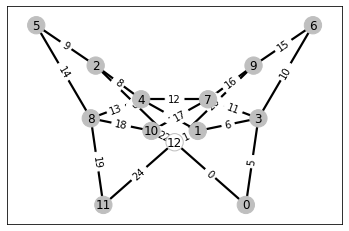

In [17]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()

In [18]:
matching_p.edges()

[(0, 12, {'fault_ids': {0}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 12, {'fault_ids': {1}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 12, {'fault_ids': {3}, 'weight': 1.0, 'error_probability': -1.0}),
 (0, 3, {'fault_ids': {5}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 3, {'fault_ids': {6}, 'weight': 1.0, 'error_probability': -1.0}),
 (1, 4, {'fault_ids': {7}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 4, {'fault_ids': {8}, 'weight': 1.0, 'error_probability': -1.0}),
 (2, 5, {'fault_ids': {9}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 6, {'fault_ids': {10}, 'weight': 1.0, 'error_probability': -1.0}),
 (3, 7, {'fault_ids': {11}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 7, {'fault_ids': {12}, 'weight': 1.0, 'error_probability': -1.0}),
 (4, 8, {'fault_ids': {13}, 'weight': 1.0, 'error_probability': -1.0}),
 (5, 8, {'fault_ids': {14}, 'weight': 1.0, 'error_probability': -1.0}),
 (6, 9, {'fault_ids': {15}, 'weight': 1.0, 'error_probability': -1.0}

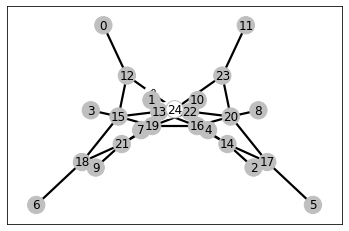

In [19]:

matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()

In [20]:
matching_my_c.edges()

[(0,
  12,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (1,
  13,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (2,
  14,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (3,
  15,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  16,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  17,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (6,
  18,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (7,
  19,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (8,
  20,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (9,
  21,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (10,
  22

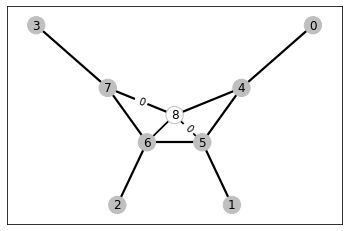

In [21]:
matching_sc = Matching.from_stim_circuit(sc_err)
matching_sc.draw()

In [22]:
matching_sc.edges()

[(0,
  4,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (1,
  5,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (2,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (3,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  None,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (4,
  5,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  6,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (5,
  None,
  {'fault_ids': {0},
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (6,
  None,
  {'fault_ids': set(),
   'weight': 2.2540580520993854,
   'error_probability': 0.095}),
 (6,
  7,
  {'fault_ids': set(),
   'weight': 2.9444389791664403,
   'error_probability': 0.05}),
 (7,
  None

In [23]:
dem = my_c.detector_error_model()
print(repr(dem))

stim.DetectorErrorModel('''
    error(0.05) D0 D12
    error(0.05) D1 D13
    error(0.05) D2 D14
    error(0.05) D3 D15
    error(0.05) D4 D16
    error(0.05) D5 D17
    error(0.05) D6 D18
    error(0.05) D7 D19
    error(0.05) D8 D20
    error(0.05) D9 D21
    error(0.05) D10 D22
    error(0.05) D11 D23
    error(0.05) D12 D15
    error(0.05) D12 L0
    error(0.05) D13 D15
    error(0.05) D13 D16
    error(0.095) D13 L0
    error(0.05) D14 D16
    error(0.05) D14 D17
    error(0.095) D14 L0
    error(0.05) D15 D18
    error(0.05) D15 D19
    error(0.05) D16 D19
    error(0.05) D16 D20
    error(0.05) D17 D20
    error(0.05) D18 D21
    error(0.05) D19 D21
    error(0.05) D19 D22
    error(0.05) D20 D22
    error(0.05) D20 D23
    error(0.095) D21
    error(0.095) D22
    error(0.05) D23
''')


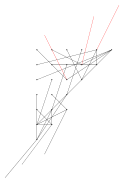

In [24]:
dem.diagram("matchgraph-svg")

In [25]:
dem_stim = sc_err.detector_error_model()
print(repr(dem_stim))

stim.DetectorErrorModel('''
    error(0.05) D0 D4
    error(0.05) D1 D5
    error(0.05) D2 D6
    error(0.05) D3 D7
    error(0.05) D4
    error(0.05) D4 D5
    error(0.05) D5 D6
    error(0.095) D5 L0
    error(0.095) D6
    error(0.05) D6 D7
    error(0.05) D7 L0
    detector(0, 4, 0) D0
    detector(2, 2, 0) D1
    detector(4, 4, 0) D2
    detector(6, 2, 0) D3
    detector(0, 4, 1) D4
    detector(2, 2, 1) D5
    detector(4, 4, 1) D6
    detector(6, 2, 1) D7
''')


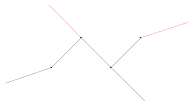

In [26]:
dem_stim.diagram("matchgraph-svg")

In [27]:
def get_num_log_errors(circuit, matching, num_shots):
    sampler = circuit.compile_detector_sampler()
    detection_events, observable_flips = sampler.sample(num_shots, separate_observables=True)
    predictions = matching.decode_batch(detection_events)
    
    
    num_errors = 0
    for shot in range(num_shots):
        actual_for_shot = observable_flips[shot]
        predicted_for_shot = predictions[shot]
        if not np.array_equal(actual_for_shot, predicted_for_shot):
            num_errors += 1
    return num_errors

num_errors = get_num_log_errors(my_c, matching_my_c, num_shots)
num_errors_stim = get_num_log_errors(sc_err, matching_from_c, num_shots)
print("for my circuit", num_errors)
print("for stim built in circuit", num_errors_stim)

for my circuit 220
for stim built in circuit 373


In [ ]:
def get_log_error_p(p_list, H_x,H_z, type, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [29]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 2
type_d = {0:"X", 1:"Z"}
type=type_d[0]


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    
    d_dict[d] = get_log_error_p(p_list, H_x,H_z, num_shots)

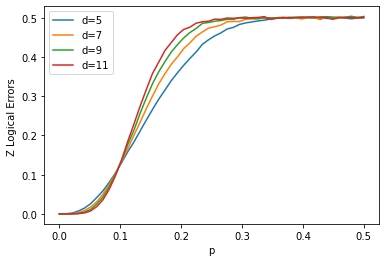

In [30]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l2_eta05_zmem.png", dpi=300)
plt.show()

In [31]:
log_error_L = []
for p in p_list:
    sc_circuit = surface_code_circuit = stim.Circuit.generated("surface_code:rotated_memory_x",rounds=1, distance=3, before_measure_flip_probability=p)
    log_errors = get_num_log_errors(sc_circuit, matching_from_c, num_shots)
    log_error_L += [log_errors/num_shots]

plt.plot(p_list, log_error_L)
plt.show()


KeyboardInterrupt: 

Now try to implement the elongated version

In [32]:
d = 3
l = 2

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

print("Hx",H_x)
# print("Hz",H_z)

Hx   (0, 0)	1
  (0, 1)	1
  (0, 3)	1
  (0, 4)	1
  (1, 6)	1
  (1, 7)	1
  (2, 1)	1
  (2, 2)	1
  (3, 8)	1
  (3, 4)	1
  (3, 5)	1
  (3, 7)	1


In [33]:
row_ind = 2
start = H_x.indptr[row_ind]
end = H_x.indptr[row_ind+1]

column_indices = H_x.indices[start:end]
print(sorted(column_indices))

[1, 2]


In [ ]:
def check_order_d_elongated(H, type):
    """ Change this for longer codes
        Right now (from STIM ex): 
         HX: 0 - TR, 1 - TL, 2 - BR, 3 - BL
         HZ: 0 - TR, 1 - BR, 2 - TL, 3 - BL
    """
    # create the order dictionary to store the qubit ordering for each plaquette
    order_d = {}
    for row in range(H.shape[0]):
        order_d[row] = []

    # get the qubit ordering for each plaquette
    for row in range(H.shape[0]):
        start = H.indptr[row]
        end = H.indptr[row+1]
        qubits = sorted(H.indices[start:end]) # the qubits in the plaquette
        
        if type == "Z":
            for i in range(len(qubits)//2):
                match_qubit_ind = np.where(qubits == (qubits[i] + d))[0][0]
                order_d[row] += [(qubits[i], row)]
                order_d[row] += [(qubits[match_qubit_ind], row)]

        if type == "X":
            for qubit in qubits:
                order_d[row] += [(qubit, row)]
    return order_d

In [35]:

order_d_x = check_order_d_elongated(H_x, "X")
print(order_d_x)
print(H_x.shape)

{0: [(0, 0), (1, 0), (3, 0), (4, 0)], 1: [(6, 1), (7, 1)], 2: [(1, 2), (2, 2)], 3: [(4, 3), (5, 3), (7, 3), (8, 3)]}
(4, 9)


In [107]:
def make_elongated_circuit_from_parity(H_x, H_z, d, p_err, eta, type):
    """ 
    create a surface code memory experiment circuit from a parity check matrix

    I think the error type I wanna use is pauli_channel_1(px, py, pz)
    """
    px = 0.5*p_err/(1+eta)
    pz = p_err*(eta/(1+eta))

    # make the circuit
    circuit = stim.Circuit()

    # get the qubit ordering
    plaq_d_x = convert_sparse_to_d(H_x)
    plaq_d_z = convert_sparse_to_d(H_z)
    
    # get the qubit ordered properly for each plaquette
    order_d_x = check_order_d_elongated(H_x, "X")
    order_d_z = check_order_d_elongated(H_z, "Z")
    
    # get the plaquettes that belong to each qubit
    qubit_d_x = qubit_to_plaq_d(H_x)
    qubit_d_z = qubit_to_plaq_d(H_z)
    
    # general parameters
    num_ancillas = len(plaq_d_x) + len(plaq_d_z) # total number of plaquettes to initialize
    num_qubits_x = len(qubit_d_x)
    num_qubits_z = len(qubit_d_z)
    
    data_q_x_list = [num_ancillas + q for q in list(qubit_d_x.keys())] # all the x data qubits
    data_q_z_list = [num_ancillas + q for q in list(qubit_d_z.keys())] # all the z data qubits
    data_q_list = data_q_x_list # change this later when wanna do X and Z seperately


    # convention - X plaqs first, then Z plaqs starting with 0
    full_plaq_L = range(num_ancillas)
    
    # reset the ancillas
    circuit.append("R", full_plaq_L)
    circuit.append("H", plaq_d_x) # only the X plaqs need H

    # reset the qubits
    for q in range(len(qubit_d_x)): # go through all the qubits, might need to change when qubit_d_x doesn't have all the qubits
        if type == "X":
            circuit.append("RX", q + num_ancillas)
        if type == "Z":
            circuit.append("R", q + num_ancillas)
 
    
    for order in order_d_x: # go through the qubits in order of gates
        q_x_list = order_d_x[order] # (qubit, ancilla)
        
        for q,p in q_x_list:
            circuit.append("CX", [p, q + num_ancillas])
        
        circuit.append("TICK")


    for order in order_d_z: # go through the qubits in order of gates
        q_z_list = order_d_z[order]

        for q,p in q_z_list:
            circuit.append("CX", [q + num_ancillas, p + len(plaq_d_x)])
    
    circuit.append("H", plaq_d_x)
    # circuit.append("PAULI_CHANNEL_1", full_plaq_L, [px,px,pz]) # measurement errors???
    circuit.append("MR", full_plaq_L)

    # for X mem measure X plaqs
    if type == "X":
        for i in range(len(plaq_d_x)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i))

        circuit.append("PAULI_CHANNEL_1", data_q_x_list, [px,px,pz])
        # circuit.append("Z_ERROR", data_q_x_list, p_err) # errors on the data qubits
        circuit.append("MX", data_q_x_list)

        # reconstruct each plaquette
        for i in plaq_d_x: 
            q_x_list = plaq_d_x[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_x + q for q in q_x_list] + [-num_ancillas + anc - num_qubits_x]
            
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(- num_qubits_x + d*q) for q in range(d)], 0) # parity of the whole line needs to be the same
    
    # Z mem measure Z plaqs
    if type == "Z":
        for i in range(len(plaq_d_z)):
            circuit.append("DETECTOR", stim.target_rec(-num_ancillas + i + len(plaq_d_x)))

        circuit.append("PAULI_CHANNEL_1", data_q_z_list, [px,px,pz])
        # circuit.append("X_ERROR", data_q_list, p_err) # errors on the data qubits
        circuit.append("M", data_q_list)

        # time to reconstruct each plaquette
        for i in plaq_d_z: 
            
            q_z_list = plaq_d_z[i] # get the qubits in the plaq
            anc = i 
            detector_list =  [-num_qubits_z + q for q in q_z_list] + [-num_ancillas +len(plaq_d_x)+ anc - num_qubits_z]
            circuit.append("DETECTOR", [stim.target_rec(d) for d in detector_list])
    
        # construct the logical observable to include - pick the top line of qubits since this is an X meas
        circuit.append("OBSERVABLE_INCLUDE", [stim.target_rec(-num_qubits_z + q) for q in range(d)], 0)
    return circuit

In [84]:
def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_stim_circuit(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    

In [85]:
d = 7
l = 4

compass_code = cc.CompassCode(d=d, l=l)
H_x, H_z = compass_code.H['X'], compass_code.H['Z']
log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']
my_c = make_circuit_from_parity(H_x,H_z, d, 0.05, "X")
print(H_z)
print(repr(my_c))

  (0, 0)	1
  (0, 7)	1
  (1, 1)	1
  (1, 2)	1
  (1, 3)	1
  (1, 4)	1
  (1, 8)	1
  (1, 9)	1
  (1, 10)	1
  (1, 11)	1
  (2, 13)	1
  (2, 12)	1
  (2, 5)	1
  (2, 6)	1
  (3, 8)	1
  (3, 15)	1
  (3, 14)	1
  (3, 7)	1
  (4, 16)	1
  (4, 17)	1
  (4, 18)	1
  (4, 19)	1
  (4, 9)	1
  (4, 10)	1
  (4, 11)	1
  :	:
  (11, 36)	1
  (11, 37)	1
  (11, 38)	1
  (11, 39)	1
  (11, 29)	1
  (11, 30)	1
  (11, 31)	1
  (12, 40)	1
  (12, 33)	1
  (12, 34)	1
  (12, 41)	1
  (13, 43)	1
  (13, 42)	1
  (13, 35)	1
  (13, 36)	1
  (14, 37)	1
  (14, 38)	1
  (14, 39)	1
  (14, 40)	1
  (14, 44)	1
  (14, 45)	1
  (14, 46)	1
  (14, 47)	1
  (15, 48)	1
  (15, 41)	1
stim.Circuit('''
    R 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
    H 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31
    RX 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 

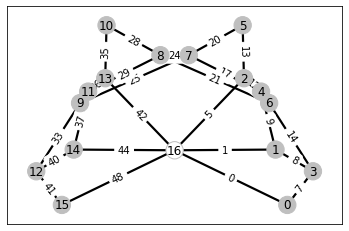

In [76]:
matching_p = Matching.from_check_matrix(H_z)
matching_p.draw()


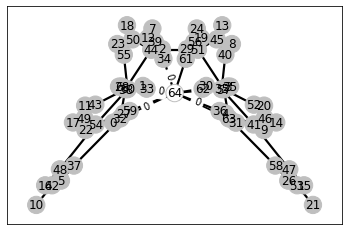

In [77]:
matching_my_c = Matching.from_stim_circuit(my_c)
matching_my_c.draw()
# my_c.diagram('detslice-with-ops-svg', tick=range(0, 5), filter_coords=['D13', ])

In [108]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

In [ ]:
p_list = np.linspace(0,0.5, 50)
d_dict = {5:[], 7:[], 9:[], 11:[]}
num_shots = 100000
l = 3
type_d = {0:"X", 1:"Z"}
type=type_d[0]
eta = 1.67

prob_scale = {'X': 0.5/(1+eta), 'Z': (1+2*eta)/(2*(1+eta)), 'CORR_Z': 1, 'TOTAL':1}

def get_log_error_p(p_list, H_x,H_z, type, eta, d, num_shots):
    log_error_L = []
    for p in p_list:
        circuit = make_elongated_circuit_from_parity(H_x, H_z, d, p, eta, type)
        matching = Matching.from_check_matrix(circuit)
        
        log_errors = get_num_log_errors(circuit, matching, num_shots)
        log_error_L += [log_errors/num_shots]
    return log_error_L
    


for d in list(d_dict.keys()):
    compass_code = cc.CompassCode(d=d, l=l)
    H_x, H_z = compass_code.H['X'], compass_code.H['Z']
    log_x, log_z = compass_code.logicals['X'], compass_code.logicals['Z']

    d_dict[d] = get_log_error_p(p_list, H_x,H_z, type,eta, d, num_shots)

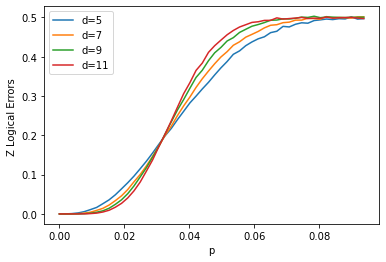

In [109]:
for d in d_dict:
    plt.plot(p_list*prob_scale[type], d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l3_eta1.67_xmem.png", dpi=300)
plt.show()

In [ ]:
for d in d_dict:
    plt.plot(p_list, d_dict[d], label=f"d={d}")
plt.xlabel("p")
plt.ylabel(f"{[v for k, v in type_d.items() if v != type][0]} Logical Errors ")
plt.legend()
plt.savefig("l3_eta05_xmem.png", dpi=300)
plt.show()